GTEx histology slides are extremely high resolution images, stored as SVS files. Most of the slide is empty and each slide from each individual varies in quality.

As a first step, we would like to obtain counts and areas of adipocytes per individual. This metric could give us useful biological information about overall adipocyte count, density (hyperplasia/trophy) per person. However, given slides can vary in quality between individuals, it's important to assess number of adipocytes across a fixed size window, as well as use many different parts of the slide to obtain an accurate (averaged) estimate.

I prepose the first step should be to obtain 'pure adipocyte' containing tiles, with each tile defined as a 299x299 pixel image. Each tile is obtained from a sliding window of 1024x1024 pixels. Each histology slide has the same microns per pixel resolution (0.49) making them comparable.

Here I have implemented an InceptionV3 pretrained Convolutional Neural Network to distinguish empty, non-adipocyte and adipocyte containing tiles using 3000 tiles from subcutaneous and 3000 tiles from visceral fat.

E.g. for Subcutaneous
1000 empty tiles = blank or partially filled
1000 adipocyte = tiles with predominately adipocytes
1000 non-adipocytes - significant non-adipocyte content (smooth muscle, endothelial cells etc).


I have used ImageNet weights to initialise the network as transfer learning with small training datasets has been shown to be a much more optimal appoach compared to training from scratch.

This network achieves an a validation accuracy of 98% - Sufficient for this task. 

In [1]:
from keras.applications.inception_v3 import InceptionV3
import os
from keras.layers import Flatten, Dense, AveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import RMSprop, SGD, adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from keras.models import load_model
import shutil
import pandas as pd
import random
import sys
import keras
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
import os
from scipy import ndimage, misc
import scipy.misc
import re,glob
import cv2

Using TensorFlow backend.


In [2]:
classes = ['empty','not_adipocyte','adipocyte']

root_train = '/well/lindgren/craig/tile_classifier/train/train_split'
root_val = '/well/lindgren/craig/tile_classifier/train/val_split'
root_total = '/well/lindgren/craig/tile_classifier/train'


In [3]:
def train_val_split(prop=0.8):
    nbr_train_samples = 0
    nbr_val_samples = 0
    random_seed=[]
    classes = ['empty','not_adipocyte','adipocyte']
    for class_id in classes:
        if id not in os.listdir(root_train):
            os.mkdir(os.path.join(root_train, class_id))
        total_images = os.listdir(os.path.join(root_total, class_id))
        nbr_train = int(len(total_images) * prop)
        np.random.shuffle(total_images)
        train_images = total_images[:nbr_train]
        val_images = total_images[nbr_train:]
        for img in train_images:
            source = os.path.join(root_total, class_id, img)
            target = os.path.join(root_train, class_id, img)
            shutil.copy(source, target)
            nbr_train_samples += 1
        if class_id not in os.listdir(root_val):
            os.mkdir(os.path.join(root_val, class_id))
        for img in val_images:
            source = os.path.join(root_total, class_id, img)
            target = os.path.join(root_val, class_id, img)
            shutil.copy(source, target)
            nbr_val_samples += 1
    print('Finish splitting train and val images!')
    print('# training samples: {}, # val samples: {}'.format(nbr_train_samples, nbr_val_samples))


In [5]:
# train_val_split(0.8)

In [6]:
train = glob.glob('train/*_split/*/*')
len(train)

2729

In [3]:
def resize(file_list):
    for filename in file_list:
        image = ndimage.imread(filename, mode="RGB")
        image_resized = misc.imresize(image, (299,299))
        out_file=filename.split('.')[0]
        cv2.imwrite(out_file+'_resized.jpg',image_resized)

In [27]:
resize(file_list=train)

In [43]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'

learning_rate = 0.0001
img_width = 299
img_height = 299
nbr_train_samples = 2181
nbr_validation_samples = 548
nbr_epochs = 20
batch_size = 64
train_data_dir = '/well/lindgren/craig/tile_classifier/train/train_split'
val_data_dir = '/well/lindgren/craig/tile_classifier/train/val_split'

best_model_file = "/well/lindgren/craig/tile_classifier/tile_adipocyte.weights.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose = 1, save_best_only = True)

In [44]:

print('Loading InceptionV3 Weights ...')
InceptionV3_notop = InceptionV3(include_top=False, weights='imagenet',
                    input_tensor=None, input_shape=(299, 299, 3))


print('Adding Average Pooling Layer and Softmax Output Layer ...')
output = InceptionV3_notop.get_layer(index = -1).output  # Shape: (8, 8, 2048)
output = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(output)
output = Flatten(name='flatten')(output)
output = Dense(3, activation='softmax', name='predictions')(output)

InceptionV3_model = Model(InceptionV3_notop.input, output)

optimizer = SGD(lr = learning_rate, momentum = 0.9, nesterov = True)
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

Loading InceptionV3 Weights ...
Adding Average Pooling Layer and Softmax Output Layer ...


In [45]:
es=EarlyStopping(monitor='val_loss', patience = 6,
                                  verbose = 1)


In [46]:
tbCallBack=keras.callbacks.TensorBoard(log_dir='Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

In [48]:
# create a generator which will produce augmented versions of training images. 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        rotation_range=180.,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True)

In [49]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        shuffle = True,
        classes = classes,
class_mode = 'categorical')

Found 2181 images belonging to 3 classes.


In [50]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [51]:
# create a generator which will produce augmented versions of validation images. 
validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        classes = classes,
        class_mode = 'categorical')


Found 548 images belonging to 3 classes.


First train for 20 epochs and then check.

In [52]:
# fit the model and track the validation loss function
InceptionV3_model.fit_generator(
        train_generator,
        steps_per_epoch = round(nbr_train_samples/batch_size),
        nb_epoch = nbr_epochs,
        validation_data = validation_generator,
        validation_steps = round(nbr_validation_samples/batch_size),
        callbacks = [best_model,tbCallBack,es])


/users/lindgren/craig/.local/lib/python3.4/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/users/lindgren/craig/.local/lib/python3.4/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., epochs=20, steps_per_epoch=34, callbacks=[<keras.ca..., validation_steps=9)`
  


Epoch 1/20
34/34 [==============================] - 304s - loss: 0.9571 - acc: 0.6020 - val_loss: 0.8634 - val_acc: 0.7117
Epoch 2/20
34/34 [==============================] - 130s - loss: 0.6143 - acc: 0.8779 - val_loss: 0.6028 - val_acc: 0.8613
Epoch 3/20
34/34 [==============================] - 129s - loss: 0.4278 - acc: 0.9204 - val_loss: 0.4461 - val_acc: 0.9069
Epoch 4/20
34/34 [==============================] - 129s - loss: 0.3505 - acc: 0.9303 - val_loss: 0.3158 - val_acc: 0.9288
Epoch 5/20
34/34 [==============================] - 129s - loss: 0.3095 - acc: 0.9271 - val_loss: 0.2260 - val_acc: 0.9507
Epoch 6/20
34/34 [==============================] - 128s - loss: 0.2680 - acc: 0.9391 - val_loss: 0.2014 - val_acc: 0.9526
Epoch 7/20
34/34 [==============================] - 130s - loss: 0.2540 - acc: 0.9292 - val_loss: 0.1740 - val_acc: 0.9617
Epoch 8/20
34/34 [==============================] - 129s - loss: 0.2234 - acc: 0.9416 - val_loss: 0.1609 - val_acc: 0.9690
Epoch 9/20
34/34

See if we can push it a little further.

In [53]:
# fit the model and track the validation loss function
InceptionV3_model.fit_generator(
        train_generator,
        steps_per_epoch = round(nbr_train_samples/batch_size),
        nb_epoch = nbr_epochs,
        validation_data = validation_generator,
        validation_steps = round(nbr_validation_samples/batch_size),
        callbacks = [best_model,tbCallBack,es])

/users/lindgren/craig/.local/lib/python3.4/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/users/lindgren/craig/.local/lib/python3.4/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., epochs=20, steps_per_epoch=34, callbacks=[<keras.ca..., validation_steps=9)`
  


Epoch 1/20
34/34 [==============================] - 132s - loss: 0.1421 - acc: 0.9595 - val_loss: 0.1226 - val_acc: 0.9708
Epoch 2/20
34/34 [==============================] - 131s - loss: 0.1389 - acc: 0.9614 - val_loss: 0.1068 - val_acc: 0.9690
Epoch 3/20
34/34 [==============================] - 127s - loss: 0.1346 - acc: 0.9568 - val_loss: 0.1071 - val_acc: 0.9763
Epoch 4/20
34/34 [==============================] - 130s - loss: 0.1532 - acc: 0.9492 - val_loss: 0.1238 - val_acc: 0.9726
Epoch 5/20
34/34 [==============================] - 128s - loss: 0.1487 - acc: 0.9566 - val_loss: 0.1120 - val_acc: 0.9726
Epoch 6/20
34/34 [==============================] - 130s - loss: 0.1274 - acc: 0.9641 - val_loss: 0.1250 - val_acc: 0.9672
Epoch 7/20
34/34 [==============================] - 131s - loss: 0.1443 - acc: 0.9589 - val_loss: 0.1018 - val_acc: 0.9781
Epoch 8/20
34/34 [==============================] - 128s - loss: 0.1419 - acc: 0.9566 - val_loss: 0.0888 - val_acc: 0.9781
Epoch 9/20
34/34

**best validation result**

33/34 [============================>.] - ETA: 3s - loss: 0.1232 - acc: 0.9612Epoch 00016: val_loss improved from 0.08775 to 0.08636, saving model to /well/lindgren/craig/tile_classifier/tile_adipocyte.weights.h5
34/34 [==============================] - 128s - loss: 0.1216 - acc: 0.9618 - val_loss: 0.0864 - val_acc: 0.9745

In [54]:
from keras.models import load_model
import os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

img_width = 299
img_height = 299
batch_size = 32
nbr_test_samples = 436163
nbr_augmentation = 2

root_path = '/well/lindgren/craig/tile_classifier/'
weights_path = '/well/lindgren/craig/tile_classifier/tile_adipocyte.weights.h5'
test_data_dir = os.path.join(root_path,'test')
# test data generator for prediction
test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)


In [ ]:

print('Loading model and weights from training process ...')
InceptionV4_model = load_model(weights_path)
random_seed=[]

for idx in range(nbr_augmentation):
    print('{}th augmentation for testing ...'.format(idx))
    if idx == 0:
       random_seed.append(np.random.random_integers(0, 1000000))
    else:
        random_seed.insert(idx,np.random.random_integers(0, 1000000))    
    test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            shuffle = False, # Important !!!
            seed = random_seed[idx],
            classes = None,
            class_mode = None)
    test_image_list = test_generator.filenames
        #print('image_list: {}'.format(test_image_list[:10]))
    print('Begin to predict for testing data ...')
    if idx == 0:
        predictions = InceptionV4_model.predict_generator(test_generator, nbr_test_samples)
    else:
        predictions += InceptionV4_model.predict_generator(test_generator, nbr_test_samples)


predictions /= nbr_augmentation

print('Begin to write submission file ..')
seed_submit=open(os.path.join(root_path, 'seed.csv'), 'w')

for item in random_seed:
    seed_submit.write("%s\n" % item)

f_submit = open(os.path.join(root_path, 'out.inception.adipocytes.csv'), 'w')
f_submit.write('image,empty,not_adipocyte,adipocyte\n')

for i, image_name in enumerate(test_image_list):
    pred = ['%.6f' % p for p in predictions[i, :]]
    print('{} / {}'.format(i, nbr_test_samples))
    f_submit.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))

f_submit.close()


Results look like this:

In [3]:
adi_c=0
not_c=0
emt_c=0
with open('out.inception.adipocytes.csv','r') as out:
    head=next(out)
    for line in out:
        if float(line.split(',')[1]) >= 0.50:
            emt_c += 1
        if float(line.split(',')[2]) >= 0.50:
            not_c += 1        
        if float(line.split(',')[3]) >= 0.50:
            adi_c += 1            

In [4]:
print('Number of images that are:\n\nempty = %s\nadipocytes = %s\nnot adipocytes \
= %s\n\nGiven that the probability of assignment is > 0.50'%(emt_c,adi_c,not_c))

Number of images that are:

empty = 1633239
adipocytes = 602893
not adipocytes = 168871

Given that the probability of assignment is > 0.50


In [5]:
import pandas as pd

results = pd.read_csv('out.inception.adipocytes.csv')
results[1:20]

image     empty  not_adipocyte  \
1       0-0_GTEX-1117F_Visceral-Omentum.jpg  0.990656       0.008732   
2   0-0_GTEX-111CU_Adipose-Subcutaneous.jpg  0.996721       0.002730   
3       0-0_GTEX-111CU_Visceral-Omentum.jpg  0.984650       0.012126   
4   0-0_GTEX-111FC_Adipose-Subcutaneous.jpg  0.983468       0.015849   
5   0-0_GTEX-111VG_Adipose-Subcutaneous.jpg  0.933613       0.059147   
6       0-0_GTEX-111VG_Visceral-Omentum.jpg  0.986918       0.011371   
7   0-0_GTEX-111YS_Adipose-Subcutaneous.jpg  0.995015       0.004464   
8       0-0_GTEX-111YS_Visceral-Omentum.jpg  0.967944       0.023842   
9   0-0_GTEX-1122O_Adipose-Subcutaneous.jpg  0.977922       0.018126   
10      0-0_GTEX-1122O_Visceral-Omentum.jpg  0.970652       0.026392   
11  0-0_GTEX-1128S_Adipose-Subcutaneous.jpg  0.983469       0.015415   
12      0-0_GTEX-1128S_Visceral-Omentum.jpg  0.994411       0.005027   
13  0-0_GTEX-113IC_Adipose-Subcutaneous.jpg  0.994965       0.003197   
14  0-0_GTEX-113JC_Adipose-Subcutaneous.jpg  0.995697       0.003849   
15      0-0_GTEX-113JC_Visceral-Omentum.jpg  0.992102       0.007148   
16  0-0_GTEX-117XS_Adipose-Subcutaneous.jpg  0.998458       0.001323   
17      0-0_GTEX-117XS_Visceral-Omentum.jpg  0.974962       0.022444   
18  0-0_GTEX-117YW_Adipose-Subcutaneous.jpg  0.973938       0.023893   
19      0-0_GTEX-117YW_Visceral-Omentum.jpg  0.970171       0.027249   

    adipocyte  
1    0.000612  
2    0.000549  
3    0.003223  
4    0.000683  
5    0.007239  
6    0.001711  
7    0.000521  
8    0.008214  
9    0.003953  
10   0.002956  
11   0.001117  
12   0.000561  
13   0.001838  
14   0.000454  
15   0.000749  
16   0.000219  
17   0.002594  
18   0.002169  
19   0.002580

In [6]:
%matplotlib inline
adipocyte_tiles = results.loc[results['adipocyte'] >= 0.5]

base_dir='test/test/'
i = 1
fig = plt.figure(figsize=(20,20))
for r in adipocyte_tiles['image'][0:25]:
    ax = fig.add_subplot(5,5,i)
    i+=1
    plt.imshow(plt.imread(base_dir+r))
    plt.title('%s'%r.split('_')[1])


In [7]:
notadipocyte_tiles = results.loc[results['not_adipocyte'] >= 0.5]

i = 1
fig = plt.figure(figsize=(20,20))
for r in notadipocyte_tiles['image'][0:25]:
    ax = fig.add_subplot(5,5,i)
    i+=1
    plt.imshow(plt.imread(base_dir+r))
    plt.title('%s'%r.split('_')[1])


In [8]:
empty_tiles = results.loc[results['empty'] >= 0.5]

i = 1
fig = plt.figure(figsize=(20,20))
for r in empty_tiles['image'][0:25]:
    ax = fig.add_subplot(5,5,i)
    i+=1
    plt.imshow(plt.imread(base_dir+r))
    plt.title('%s'%r.split('_')[1])


In [9]:
results['Max'] = results[['adipocyte','not_adipocyte','empty']].idxmax(axis=1)

In [16]:
# create three test result folders.
# for each max value, put the corresponding file into that folder.

In [10]:
adipocyte_tiles['sampleID'] = [entry.split('_')[1] for entry in adipocyte_tiles['image']]
results['sampleID'] = [entry.split('_')[1] for entry in results['image']]

/users/lindgren/craig/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
adipocyte_tiles.head()[1:5]

image     empty  not_adipocyte  \
2210   0-10240_GTEX-RWSA_Adipose-Subcutaneous.jpg  0.072163       0.005093   
4193  0-11264_GTEX-13QJC_Adipose-Subcutaneous.jpg  0.001999       0.001127   
4788   0-11264_GTEX-RWSA_Adipose-Subcutaneous.jpg  0.000227       0.000176   
5482  0-12288_GTEX-13QJC_Adipose-Subcutaneous.jpg  0.000577       0.000240   

      adipocyte    sampleID  
2210   0.922744   GTEX-RWSA  
4193   0.996874  GTEX-13QJC  
4788   0.999597   GTEX-RWSA  
5482   0.999183  GTEX-13QJC

In [19]:
counts=adipocyte_tiles['sampleID'].value_counts()
counts = pd.DataFrame(data=counts)
counts=counts[1:]

How many adipocyte tiles does each sample have?

(array([ 35.,  98., 181., 183., 118.,  54.,  34.,  15.,  10.,   4.]),
 array([  22.,  196.,  370.,  544.,  718.,  892., 1066., 1240., 1414.,
        1588., 1762.]),
 <a list of 10 Patch objects>)

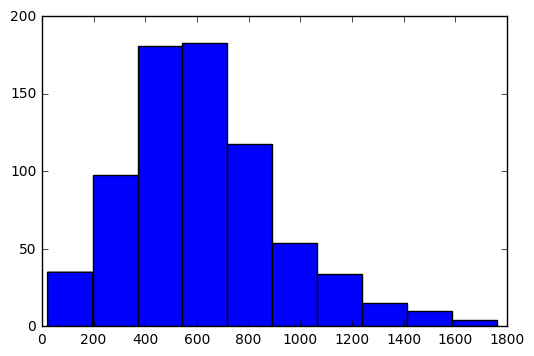

In [24]:
from ggplot import *

plt.hist(counts['sampleID'])
# Median: 584.5 Min-Max:  [22, 1762] Mean:  624.181693989071


In [25]:
adipocyte_tiles.head()

image     empty  not_adipocyte  \
1615  0-10240_GTEX-13QJC_Adipose-Subcutaneous.jpg  0.002056       0.000137   
2210   0-10240_GTEX-RWSA_Adipose-Subcutaneous.jpg  0.072163       0.005093   
4193  0-11264_GTEX-13QJC_Adipose-Subcutaneous.jpg  0.001999       0.001127   
4788   0-11264_GTEX-RWSA_Adipose-Subcutaneous.jpg  0.000227       0.000176   
5482  0-12288_GTEX-13QJC_Adipose-Subcutaneous.jpg  0.000577       0.000240   

      adipocyte    sampleID  
1615   0.997807  GTEX-13QJC  
2210   0.922744   GTEX-RWSA  
4193   0.996874  GTEX-13QJC  
4788   0.999597   GTEX-RWSA  
5482   0.999183  GTEX-13QJC

In [26]:
print("Total number of samples ",len(results['sampleID'].unique()),
      "Have Adipocyte tiles:", len(adipocyte_tiles['sampleID'].unique()))

Total number of samples  733 Have Adipocyte tiles: 733


How many samples have at least 2 good adipocyte tiles:

In [36]:
counts[counts >= 50.0 ].count()[0]

730

In [29]:
adipocyte_tiles.to_csv("adipoTiles.labeled.csv",sep=",",index=False)

In [41]:
print('Number of tiles with adipocytes predicted present: {}'.format(len(adipocyte_tiles)))

Number of tiles with adipocytes predicted present: 602893
